# Competition Overview

To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creating an algorithm that can identify a specific type of cactus in aerial imagery.

This competition has been inspired by an existing competition on Kaggle.

## Acknowledgments

This is an original competition defined here.

## References

Efren López-Jiménez, Juan Irving Vasquez-Gomez, Miguel Angel Sanchez-Acevedo, Juan Carlos Herrera-Lozada, Abril Valeria Uriarte-Arcia, "Columnar Cactus Recognition in Aerial Images using a Deep Learning Approach." *Ecological Informatics*. 2019.

Acknowledgements to Consejo Nacional de Ciencia y Tecnología. Project cátedra 1507. Instituto Politècnico Nacional. Universidad de la Cañada. Contributors: Eduardo Armas Garca, Rafael Cano Martnez and Luis Cresencio Mota Carrera. J.I. Vasquez-Gomez, JC. Herrera Lozada. Abril Uriarte, Miguel Sanchez.

## Dataset Description and Files

The dataset contains a large number of 32 x 32 thumbnail images that are aerial photos of a columnar cactus (*Neobuxbaumia tetetzo*). The image file name corresponds to its id. You must create a classifier capable of predicting whether an image contains a cactus.

**Files:**

- `train/` - training set images
- `test/` - test set images (labels are not provided)
- `train.csv` - CSV file with training labels (`has_cactus = 1` if cactus is present)
- `sample_submission.csv` - sample submission file (can be discarded)

## Metrics and Evaluation

Since the test set has no labels, you must create a valid validation strategy by splitting the training set into training, validation, and test subsets. Note that the performance metric is not predefined. You need to first characterize your data (e.g., check the class balance) and then decide on an appropriate metric for binary classification.

_Original approaches: do not hesitate to experiment. For example, you might even try to use a "Visual Question Answering" model to synthetically label test images._

In [1]:
# ...existing imports...
import os
import pandas as pd
import numpy as np

# TensorFlow and model libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# For evaluating performance
from sklearn.model_selection import train_test_split, StratifiedKFold

# Read training labels
train_df = pd.read_csv("train.csv")
print("Number of training samples:", len(train_df))
print(train_df.head())

/Users/mymac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Number of training samples: 17500
                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


In [ ]:
# Set up k-fold cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_idx, val_idx in kf.split(train_df, train_df["has_cactus"]):
    print(f"Fold {fold} - Train size: {len(train_df.iloc[train_idx])}, Validation size: {len(train_df.iloc[val_idx])}")
    # Example: selecting the first fold for training and evaluation
    if fold == 2:
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]
    fold += 1
print("Using Fold 1 for training and validation.")

# Store the training history for further k-fold evaluation
history_folds = []

Fold 1 - Train size: 14000, Validation size: 3500
Fold 2 - Train size: 14000, Validation size: 3500
Fold 3 - Train size: 14000, Validation size: 3500
Fold 4 - Train size: 14000, Validation size: 3500
Fold 5 - Train size: 14000, Validation size: 3500
Using Fold 1 for training and validation.


In [9]:
# Set up ImageDataGenerators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define paths
train_dir = "archive/train/train/"
test_dir = "archive/test/test/"

# Create generators using the selected fold
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_fold,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_fold,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 14000 validated image filenames.
Found 3500 validated image filenames.


In [10]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model using the selected fold
EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Append history to history_folds list for k-fold analysis
history_folds.append(history)

Epoch 1/20


/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8454 - loss: 0.3670 - val_accuracy: 0.8697 - val_loss: 0.3057
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9253 - loss: 0.2035 - val_accuracy: 0.9631 - val_loss: 0.1076
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9405 - loss: 0.1648 - val_accuracy: 0.9503 - val_loss: 0.1412
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9481 - loss: 0.1513 - val_accuracy: 0.9074 - val_loss: 0.2473
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9531 - loss: 0.1337 - val_accuracy: 0.9480 - val_loss: 0.1446
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9554 - loss: 0.1263 - val_accuracy: 0.9720 - val_loss: 0.0772
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9619 - loss: 0.1067 - val_accuracy: 0.9766 - val_loss: 0.0663
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9609 - loss: 0.1039 - val_accuracy: 0.915

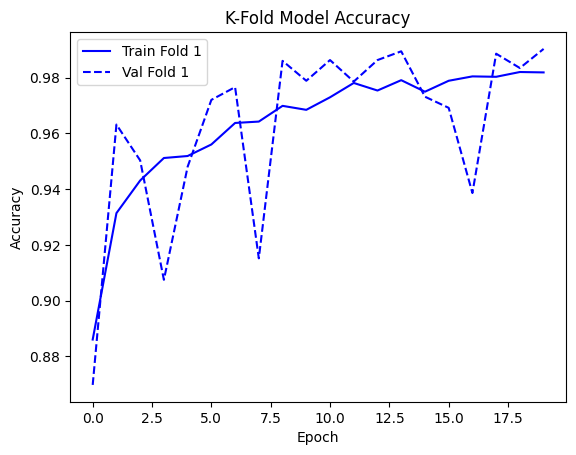

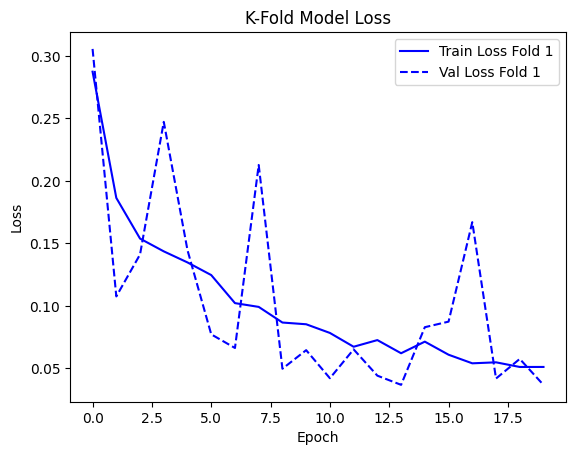

In [12]:
# Evaluate and visualize performance across the k-folds
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm']

plt.figure()
for i, hist in enumerate(history_folds):
    plt.plot(hist.history['accuracy'], label=f'Train Fold {i+1}', color=colors[i])
    plt.plot(hist.history['val_accuracy'], label=f'Val Fold {i+1}', linestyle='--', color=colors[i])
plt.title('K-Fold Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
for i, hist in enumerate(history_folds):
    plt.plot(hist.history['loss'], label=f'Train Loss Fold {i+1}', color=colors[i])
    plt.plot(hist.history['val_loss'], label=f'Val Loss Fold {i+1}', linestyle='--', color=colors[i])
plt.title('K-Fold Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate predictions for the test set
test_filenames = sorted(os.listdir(test_dir))
test_df = pd.DataFrame({"id": test_filenames})

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,  # no labels
    target_size=(32, 32),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

preds = model.predict(test_generator)
pred_labels = (preds > 0.5).astype(int).reshape(-1)

print("Example predictions on test data:")
for i in range(10):
    print(test_df.iloc[i]['id'], "->", pred_labels[i])

In [ ]:
# Save submission file
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "has_cactus": pred_labels
})
submission_df.to_csv("my_submission.csv", index=False)
print("\nFile 'my_submission.csv' has been saved successfully.")

# Show first 10 rows of submission
submission_df.head(10)